#   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> NLP Project: Text Classification (BBC)

#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> loading libraries  

In [1]:
import numpy  as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import re #, string, unicodedata
#from   bs4 import BeautifulSoup

#from   textblob  import TextBlob, Word
from   wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#import spacy

#from sklearn.svm           import SVC
#from sklearn.naive_bayes   import MultinomialNB
#from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model  import LogisticRegression, SGDClassifier
from sklearn               import model_selection, preprocessing, naive_bayes, ensemble 
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics       import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
import nltk   # pip install --upgrade nltk

nltk.download('punkt')
#from nltk.tokenize.toktok import ToktokTokenizer
#from nltk.tokenize        import word_tokenize, sent_tokenize

nltk.download('stopwords') 
from nltk.corpus           import stopwords

nltk.download('wordnet')
from nltk.stem             import WordNetLemmatizer 

#from nltk.stem            import LancasterStemmer 
#from nltk.stem.porter     import PorterStemmer

[nltk_data] Downloading package punkt to C:\Users\EZ-
[nltk_data]     Tech\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\EZ-
[nltk_data]     Tech\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\EZ-
[nltk_data]     Tech\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> loading dataset

In [3]:
data = pd.read_csv('bbcText.csv',delimiter=',')
data.head(1)

,category,text
0,tech,tv future in the hands of viewers with home th...


In [4]:
data = data.rename( columns={'category':'label'} )
data = data[ ['text','label'] ]
data.head()

,text,label
0,tv future in the hands of viewers with home th...,tech
1,worldcom boss left books alone former worldc...,business
2,tigers wary of farrell gamble leicester say ...,sport
3,yeading face newcastle in fa cup premiership s...,sport
4,ocean s twelve raids box office ocean s twelve...,entertainment


#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> EDA

In [5]:
data.shape

(2225, 2)

In [6]:
# removing duplicates
print('Before Treatment:  n duplicates =', sum(data.duplicated())) 
if sum( data.duplicated() ) > 0:
    data = data.drop_duplicates()
    data.index = range( data.shape[0] )
print('After Treatment:   n duplicates =', sum(data.duplicated())) 

Before Treatment:  n duplicates = 99
After Treatment:   n duplicates = 0


In [7]:
# removing null
data = data.dropna()
data.isnull().sum()

text     0
label    0
dtype: int64

In [8]:
data.describe()

,text,label
count,2126,2126
unique,2126,5
top,tv future in the hands of viewers with home th...,sport
freq,1,504


In [9]:
data['label'].value_counts()

label
sport            504
business         503
politics         403
entertainment    369
tech             347
Name: count, dtype: int64

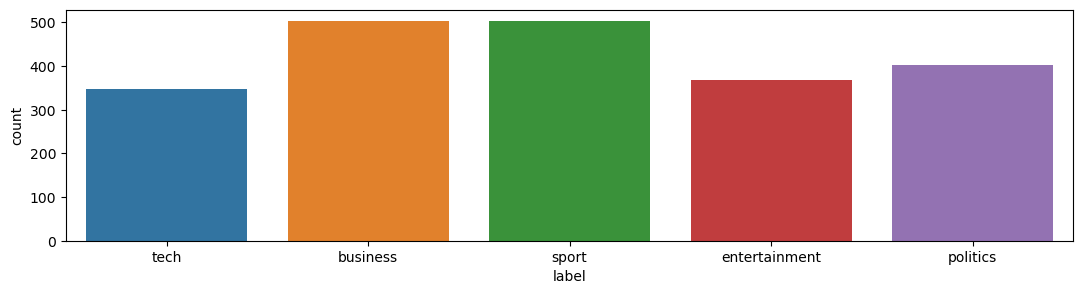

In [10]:
fig, ax = plt.subplots(figsize=(13,3))
sns.countplot( data=data, x='label', ax=ax )
plt.show()

#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> NLP Preprocessing

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Remove New Lines

In [11]:
# removing punctuations
def remove_new_lines(text): return re.sub('[\n]',' ', text)
data['text'] = data['text'].apply(remove_new_lines)

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Remove Punctuations

In [12]:
# removing punctuations
def remove_punctuations(text): return re.sub('[^a-zA-Z]',' ', text)
data['text'] = data['text'].apply(remove_punctuations)

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Converting to LowerCase

In [13]:
# converting text to lower_case
def into_lower(text): return text.lower()
data['text'] = data['text'].apply(into_lower)

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Set & Remove Stop_Words

<span style="font-family:Arial; font-weight:Bold; font-size:1.2em; color:#00b3e5;"> Setting Stop_Words

In [14]:
# Setting English StopWords
stop_words = set( stopwords.words('english') )
new_words  = [ 'some','one','like','time','br','movie','film','could','would','get','make','really','see',
               'well','much','good','great','first','last','people','also','bad','worst','show','may','thing',
               'make','go','think','know','watch','look','many','said','say','mr','new','take','told','back' ] 
stop_words = stop_words.union(new_words)

<span style="font-family:Arial; font-weight:Bold; font-size:1.2em; color:#00b3e5;"> Removing Stop_Words

In [15]:
def remove_stop_words(text):
    Clean = []
    for word in text.split():
        if word not in stop_words:
            Clean.append(word) 
    return ' '.join( Clean )

data['text'] = data['text'].apply( remove_stop_words )
data.head()

,text,label
0,tv future hands viewers home theatre systems p...,tech
1,worldcom boss left books alone former worldcom...,business
2,tigers wary farrell gamble leicester rushed ma...,sport
3,yeading face newcastle fa cup premiership side...,sport
4,ocean twelve raids box office ocean twelve cri...,entertainment


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Lemmatizing

In [16]:
# Lemmatizing 
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    Clean = []
    for word in text.split():
        Clean.append( lemmatizer.lemmatize(word) )
    return ' '.join( Clean )

data['text'] = data['text'].apply(lemmatize_text)
data.head()

,text,label
0,tv future hand viewer home theatre system plas...,tech
1,worldcom bos left book alone former worldcom b...,business
2,tiger wary farrell gamble leicester rushed mak...,sport
3,yeading face newcastle fa cup premiership side...,sport
4,ocean twelve raid box office ocean twelve crim...,entertainment


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Stemming
 - Faster but less accurate than Lemmatizer

In [17]:
# Stemming
''' 
Stemmer = PorterStemmer()

def stem_text(text):
    Clean = []
    for word in text.split():
        Clean.append( Stemmer.stem(word) )
    return ' '.join( Clean )

data['text'] = data['text'].apply(stem_text)
data.head()
''' 
pass

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Bag of Words (List)

In [18]:
def bag_of_words_maker(df,ft):
    texts = df[ft]
    bag   = []
    for text in texts:
        for word in text.split():
            bag.append( word )
    return bag

bag_of_words = bag_of_words_maker( data, 'text' )
bag_of_words[:5]

['tv', 'future', 'hand', 'viewer', 'home']

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Bag of Words (DataFrame)

In [19]:
bag_of_words = pd.DataFrame( bag_of_words, columns=['word'] )
bag_of_words.head(3)

,word
0,tv
1,future
2,hand


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Words Count (DataFrame)

In [20]:
words_count         = pd.DataFrame( bag_of_words[ 'word' ].value_counts() )
words_count['word'] = words_count.index
words_count.index   = range( words_count.shape[0] )
words_count.head(5)

,count,word
0,3193,year
1,1938,u
2,1452,game
3,1235,two
4,1186,world


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Keeping Top Words

In [21]:
n = 1000
Top_Words = words_count.loc[:n,'word'].tolist()
Top_Words[:5]

['year', 'u', 'game', 'two', 'world']

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Text Reduction

In [22]:
def text_reduct( text ):
    Clean = []
    for word in text.split():
        if word in Top_Words:
            Clean.append(word)
    return ' '.join(Clean)

data['text'] = data['text'].apply(text_reduct)
data.head()

,text,label
0,tv future hand viewer home theatre system high...,tech
1,bos left book former bos accused bn bn fraud n...,business
2,making bid andy britain rugby league captain c...,sport
3,face newcastle cup premiership side newcastle ...,sport
4,box office crime robert gone number u box offi...,entertainment


#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Train-Valid-Test Split (Text)

In [23]:
n  = data.shape[0]

Train_Text  = data.text[           :int(.8*n) ]
Valid_Text  = data.text[  int(.8*n):int(.9*n) ]
Test_Text   = data.text[  int(.9*n):          ]

Train_Label = data.label[          :int(.8*n) ]
Valid_Label = data.label[ int(.8*n):int(.9*n) ]
Test_Label  = data.label[ int(.9*n):          ]

In [24]:
Valid_Text[:3]

1700    charge chelsea bos face football association a...
1701    aim mobile gaming industry set number high dev...
1702    injury england positive despite ruling six nat...
Name: text, dtype: object

In [25]:
Valid_Label[:3]

1700    sport
1701     tech
1702    sport
Name: label, dtype: object

#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Cool Image of Top Phrases

In [26]:
vec=CountVectorizer( min_df=0, max_df=500, binary=False, ngram_range=(2,3) ).fit(Train_Text)
bag=vec.transform(Train_Text)

s = bag.sum(axis=0)
f = [ (word,s[0,idx]) for word, idx in vec.vocabulary_.items() ]
f = sorted( f, key=lambda x: x[1], reverse=True )
f[:5]

[('year old', 273),
 ('prime minister', 230),
 ('chief executive', 164),
 ('bn bn', 161),
 ('bbc news', 136)]

In [27]:
Top_N = 30
Top_Phrases = pd.DataFrame(f[:Top_N], columns=['Word','Freq'])
Top_Phrases.head()

,Word,Freq
0,year old,273
1,prime minister,230
2,chief executive,164
3,bn bn,161
4,bbc news,136


In [28]:
Top_Corpus = []
for w in Top_Phrases['Word']:
    w1,w2 = w.split()
    Top_Corpus.append(str(w1+'_'+w2))
Top_Corpus = ' '.join(Top_Corpus)
Top_Corpus

'year_old prime_minister chief_executive bn_bn bbc_news general_election tony_blair six_nation year_ago liberal_democrat mobile_phone two_year michael_howard next_year human_right bbc_radio five_year gordon_brown kilroy_silk interest_rate home_secretary three_month world_cup lib_dems manchester_united grand_slam long_term stock_market three_year news_website'

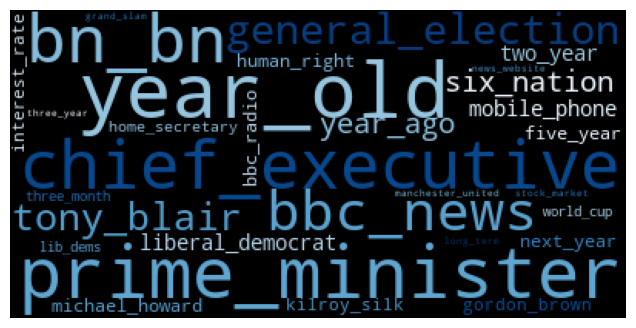

In [29]:
wordcloud = WordCloud( 
    
    #background_color='LightSeaGreen', colormap='RdBu',
    #background_color='black', colormap='Greens',
    background_color='black', colormap='Blues',
    
    stopwords        = stop_words,
    max_words        = Top_N,
    max_font_size    = 50,
    random_state     = 7 
    ).generate( str(Top_Corpus) ) 

fig = plt.figure(figsize=(13,4))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Count Vectorizer

In [30]:
# Count vectorizer for bag of words
cv=CountVectorizer( min_df=0, max_df=500, binary=False, ngram_range=(1,3) )

In [31]:
# transformed Data
CV_Train = cv.fit_transform( Train_Text )
CV_Valid = cv.transform(     Valid_Text )
CV_Test  = cv.transform(     Test_Text  )

In [32]:
print('BOW CV_Train:', CV_Train.shape)
print('BOW CV_Valid:', CV_Valid.shape)
print('BOW CV_Test: ', CV_Test.shape )

BOW CV_Train: (1700, 292129)
BOW CV_Valid: (213, 292129)
BOW CV_Test:  (213, 292129)


In [33]:
Train_Text

0       tv future hand viewer home theatre system high...
1       bos left book former bos accused bn bn fraud n...
2       making bid andy britain rugby league captain c...
3       face newcastle cup premiership side newcastle ...
4       box office crime robert gone number u box offi...
                              ...                        
1695    india bn deal air bn deal india low cost airli...
1696    sell stake spain share group news stake london...
1697    bos way side got european football cup win pla...
1698    england former australian david england stop d...
1699    mp income senior official two body private inc...
Name: text, Length: 1700, dtype: object

#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> TF-IDF Vectorizer

In [34]:
# TF-IDF vectorizer for bag of words
tf = TfidfVectorizer( min_df=0, max_df=500, use_idf=True, ngram_range=(1,3) )

In [35]:
# transformed Data
TF_Train = tf.fit_transform( Train_Text )
TF_Valid = tf.transform(     Valid_Text )
TF_Test  = tf.transform(     Test_Text  )

In [36]:
print('BOW TF_Train:', TF_Train.shape)
print('BOW TF_Valid:', TF_Valid.shape)
print('BOW TF_Test: ', TF_Test.shape )

BOW TF_Train: (1700, 292129)
BOW TF_Valid: (213, 292129)
BOW TF_Test:  (213, 292129)


#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Logistic Regression Model

In [37]:
model = LogisticRegression( penalty='l2', max_iter=500, C=1, random_state=7 )

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Model with Count Vectorizer

In [38]:
# Fitting
CV_Model = model.fit( CV_Train, Train_Label )
print(CV_Model)

LogisticRegression(C=1, max_iter=500, random_state=7)


In [39]:
# Predicting
CV_Pred = CV_Model.predict( CV_Valid )
CV_Pred

array(['sport', 'tech', 'sport', 'tech', 'sport', 'sport', 'business',
       'business', 'tech', 'sport', 'business', 'tech', 'politics',
       'sport', 'business', 'entertainment', 'entertainment', 'tech',
       'politics', 'sport', 'sport', 'business', 'tech', 'entertainment',
       'entertainment', 'politics', 'politics', 'business', 'sport',
       'entertainment', 'entertainment', 'business', 'sport', 'politics',
       'business', 'sport', 'entertainment', 'tech', 'politics',
       'politics', 'sport', 'sport', 'politics', 'business', 'business',
       'business', 'business', 'entertainment', 'business', 'politics',
       'politics', 'tech', 'tech', 'entertainment', 'politics',
       'entertainment', 'business', 'politics', 'sport', 'sport',
       'entertainment', 'tech', 'business', 'sport', 'business',
       'business', 'politics', 'sport', 'sport', 'politics', 'politics',
       'entertainment', 'entertainment', 'politics', 'business',
       'politics', 'politics', 

In [40]:
# Scoring (Accuracy)  
CV_Score = accuracy_score( CV_Pred, Valid_Label )
print("CV_Score :",CV_Score)

CV_Score : 0.971830985915493


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Model with TF-IDF Vectorizer

In [41]:
# Fitting
TF_Model = model.fit( TF_Train, Train_Label )
print(TF_Model)

LogisticRegression(C=1, max_iter=500, random_state=7)


In [42]:
# Predicting
TF_Pred = TF_Model.predict( TF_Valid )
TF_Pred

array(['sport', 'tech', 'sport', 'tech', 'sport', 'sport', 'business',
       'business', 'tech', 'sport', 'business', 'tech', 'politics',
       'sport', 'business', 'entertainment', 'entertainment', 'tech',
       'politics', 'sport', 'sport', 'business', 'tech', 'entertainment',
       'entertainment', 'politics', 'politics', 'business', 'sport',
       'entertainment', 'entertainment', 'business', 'sport', 'politics',
       'business', 'sport', 'entertainment', 'tech', 'politics',
       'politics', 'sport', 'sport', 'politics', 'business', 'business',
       'business', 'business', 'entertainment', 'business', 'politics',
       'politics', 'tech', 'tech', 'entertainment', 'politics',
       'entertainment', 'business', 'politics', 'sport', 'sport',
       'business', 'tech', 'business', 'sport', 'business', 'business',
       'politics', 'sport', 'sport', 'politics', 'politics',
       'entertainment', 'entertainment', 'politics', 'business',
       'politics', 'politics', 'busi

In [43]:
# Scoring (Accuracy)  
TF_Score = accuracy_score( TF_Pred, Valid_Label )
print("TF_Score :",TF_Score)

TF_Score : 0.9812206572769953


#####   

#####   